In [4]:
import numpy as np
from scipy.fft import fft2,ifft2,fftfreq,fftshift,ifftshift
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from scipy.special import spherical_jn, spherical_yn , hankel1,lpmv
import cmath

In [2]:
def Optica(U0,X,Y,z,lamb):
    A = (fft2((U0)))
    Lx = np.max(X)
    Ly= np.max(Y)

    deltax = 2*Lx/len(U0)
    deltay = 2*Ly/len(U0)    


    fx = ( fftfreq(len(U0),deltax) )  
    fy = ( fftfreq(len(U0),deltay) )   
    
    Fx,Fy = np.meshgrid(fx,fy)
    K = 2*np.pi/lamb

    # Handle cases where u is negative
    u = K**2-(2*np.pi*Fx)**2-(2*np.pi*Fy)**2
    sqrt_u = 1j*z*np.sqrt(abs(u))
    sqrt_u[np.where(u<0)] = 1j*sqrt_u[np.where(u<0)]

    return  ( ifft2( ( A*np.exp(sqrt_u) ) ) )

def Optica_G(U0,X,Y,lamb,L,z):
    A= 1
    for i in range(len(L)):
      A =  Optica(A*U0[i],X,Y,L[i],lamb)

    return Optica(A*U0[-1],X,Y,z,lamb)

In [3]:
def FiguraOptica2(U0,X,Y,lamb,z):
  Z=[]
  for i in range(len(z)):
    U = Optica(U0,X,Y,z[i],lamb)
    Z.append(abs(U[len(U0)//2])**2)
  return Z

def FiguraOptica(U0,X,Y,lamb,L,z):
  A= U0[0]
  Z=[]
  #A =  Optica(A,X,Y,L[0],lamb)
  for i in range(len(L)):
    A =  Optica(A*U0[i],X,Y,L[i],lamb)

  for i in range(len(z)):
    U = Optica(A*U0[-1],X,Y,z[i],lamb)
    Z.append(abs(U[len(U[0])//2])**2)
  return Z

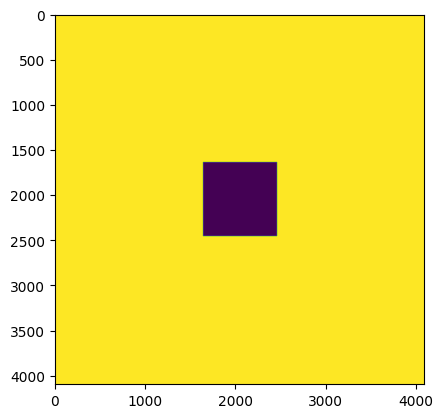

In [100]:
N = 4096
R,r = 8,3
x = np.linspace(-5*R,5*R,N,endpoint=False)
X,Y = np.meshgrid(x,x)

A0 = (X**2+Y**2>R**2).astype('float32')
A1 = ((abs(X)>R)+(abs(Y)>R)).astype('float32')

plt.imshow(A1)

In [101]:
L = np.array([8,2])
A = np.array([A1,A0,A1])
z = 1500
lamb = 0.632*10**(-3)

UN = Optica_G(A,X,Y,lamb,L,z-L[0]*len(L))
U0 = Optica(A1,X,Y,z,lamb)

(-0.5, 900.5, 900.5, -0.5)

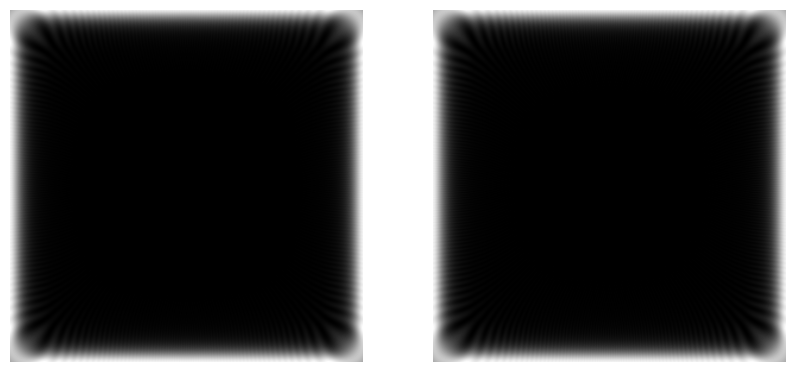

In [102]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(abs(np.transpose(UN[np.where(abs(x)<1.1*R)[0]])[np.where(abs(x)<1.1*R)[0]])**2,cmap='gray')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(abs(np.transpose(U0[np.where(abs(x)<1.1*R)[0]])[np.where(abs(x)<1.1*R)[0]])**2,cmap='gray')
ax2.axis('off')

**So**

We can define a rotated square using
\begin{equation}
    |cos(\phi) \cdot X + sin(\phi) \cdot Y| + |cos(\phi) \cdot Y - sin(\phi) \cdot X| > R
\end{equation}

In [4]:
N = 4096
R = 8
x = np.linspace(-5*R,5*R,N,endpoint=False)
X,Y = np.meshgrid(x,x)

A = []
L = []
A0 = (X**2+Y**2>R**2).astype('float32')
for i in range(0,180,1):
    phi = i*np.pi/180
    A.append(  ( abs(np.cos(phi)*X + np.sin(phi)*Y) + abs(np.cos(phi)*Y - np.sin(phi)*X) >R  ).astype('float32') )

    if i!=0:
        L.append(0.01)



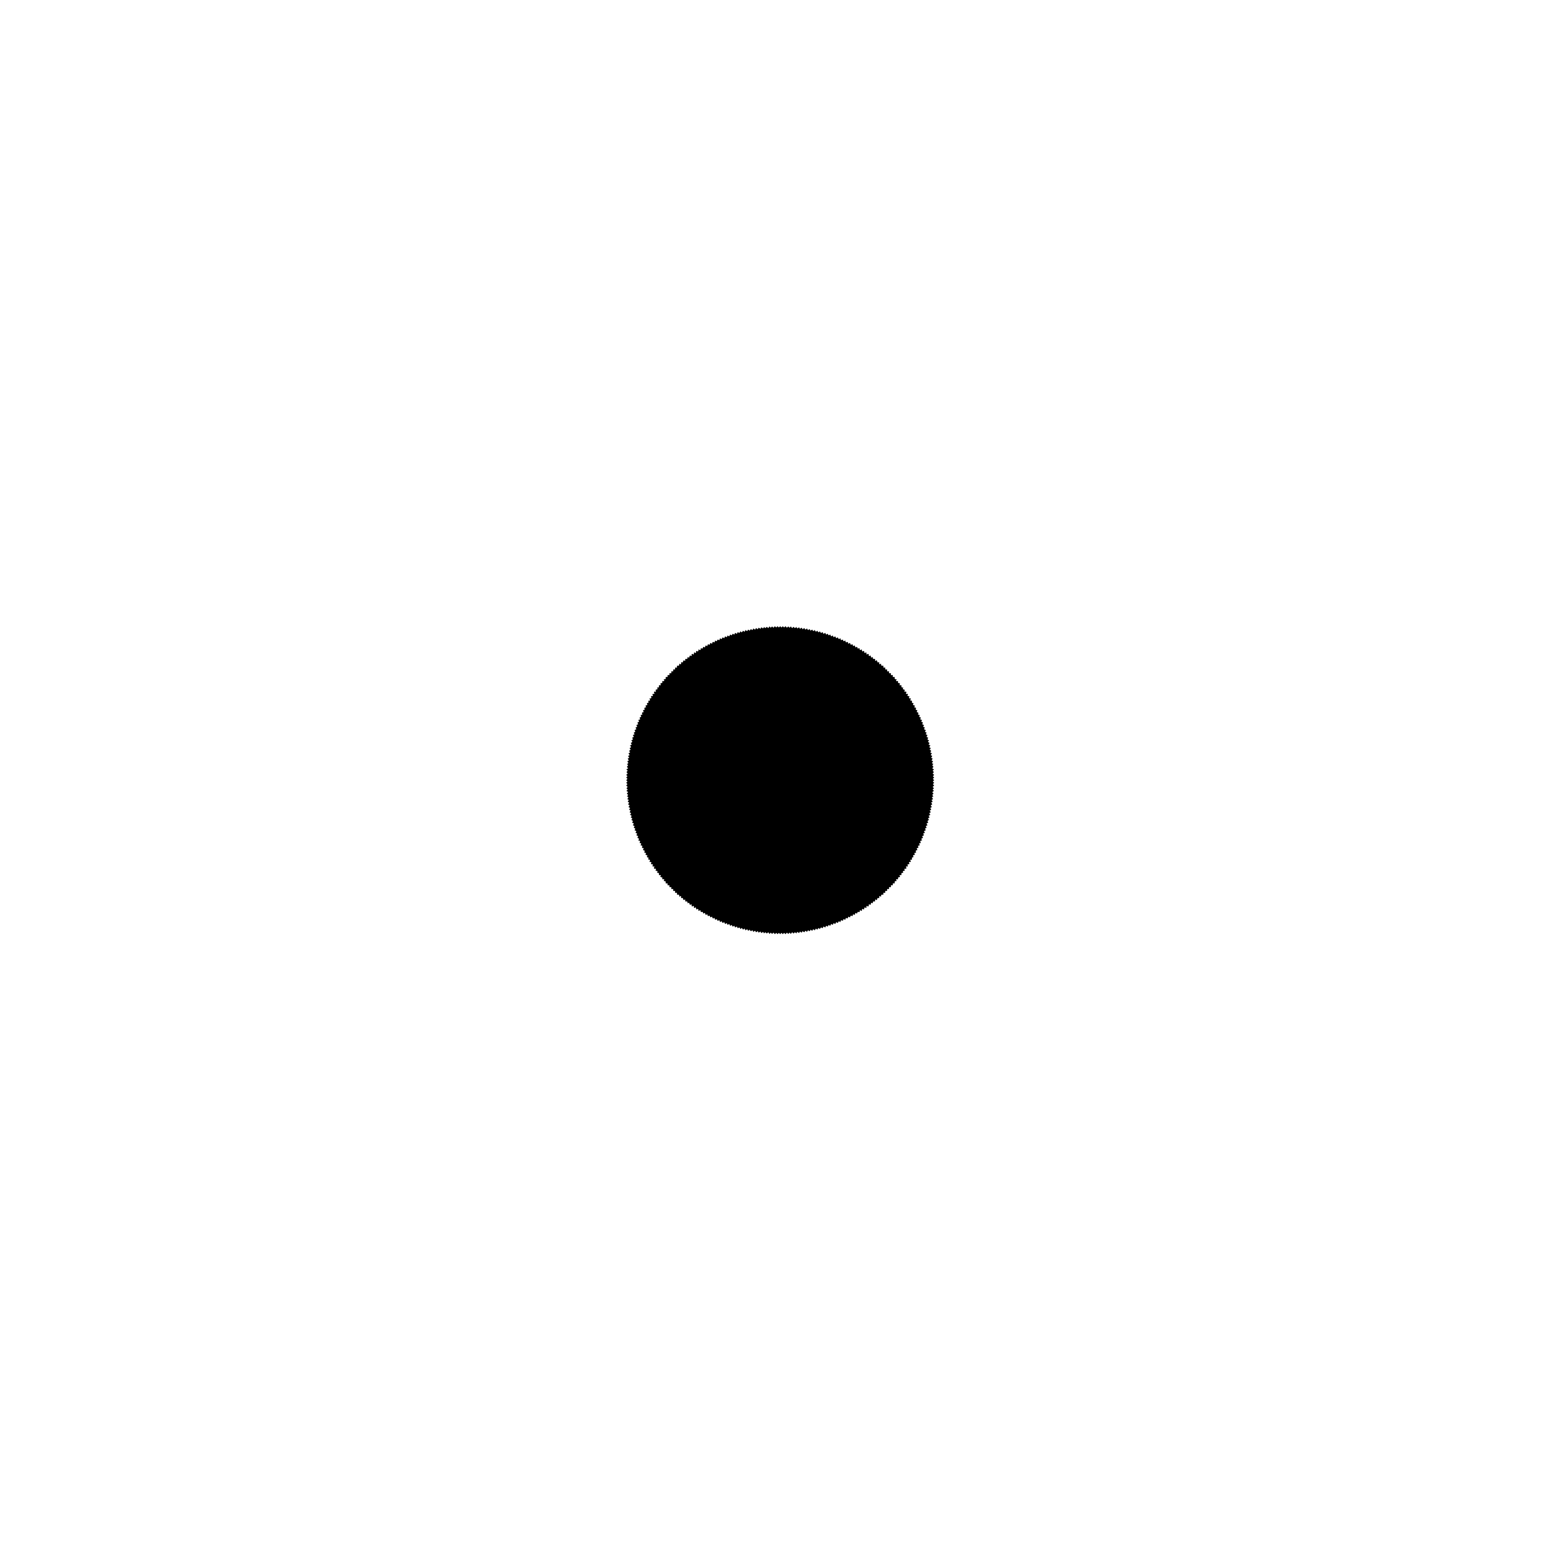

In [5]:
A1 = A[0]

for i in range(1,len(A)):
    A1=A[i]*A1

fig,ax = plt.subplots(1,1, figsize = (20,20))
ax.imshow(A1,cmap='gray')
ax.axis('off')
#ax[1].imshow(A0,cmap='gray')
#ax[1].axis('off')

plt.savefig('squaredcircle.svg')

In [51]:
z = np.array([60*R,120*R,180*R,240*R,300*R,360*R,420*R,480*R])
lamb = 0.632*10**(-3)
L = np.array(L)

ZN01 = FiguraOptica(A,X,Y,lamb,L,z + np.sum( L/L[0]*8 ) - np.sum(L))
ZN2 = FiguraOptica(A,X,Y,lamb,L/L[0]*1,z +np.sum(L/L[0]*8) -np.sum(L/L[0]*1) )
ZN3 = FiguraOptica(A,X,Y,lamb,L/L[0]*8,z)

Z0 = FiguraOptica2(A0,X,Y,lamb,z+np.sum(L/L[0]*8)  )
#UN = Optica_G(A,X,Y,lamb,L,z-L[0]*len(L))
#U0 = Optica(A0,X,Y,z,lamb)

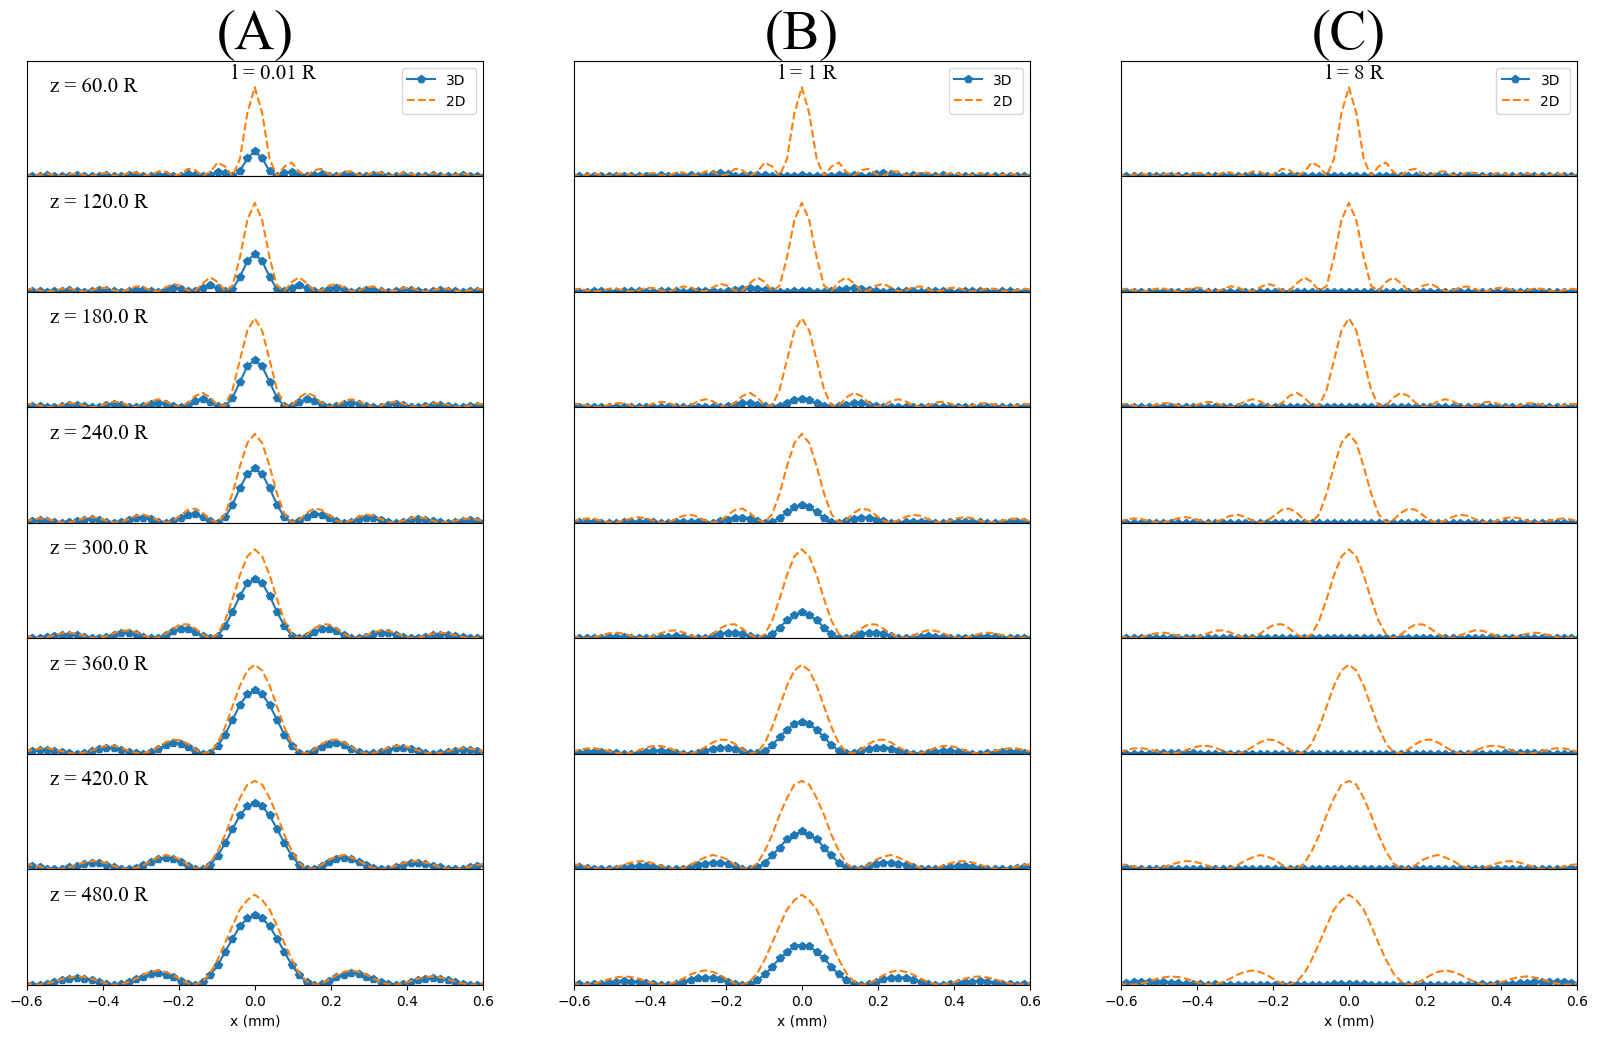

In [52]:
import matplotlib.gridspec as gridspec
b = [0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6]
# Create the figure and grid specification
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(len(z),3, hspace=0.0)
l=[0.01,1,8]
llet = ['A','B','C']
# Create subplots in the first column
for j in range(3):
    
    for u in range(len(z)):
        ax1 = fig.add_subplot(gs[u, j])

        # Plot Fourier Optics data
        if j==0:
            UU15 = ZN01[u]
        if j==1:
            UU15 = ZN2[u]
        if j==2:
            UU15 = ZN3[u]
        UUU = Z0[u]

        ax1.plot(x, UU15, 'p-', label=f'3D')
        ax1.plot(x,UUU ,'--',label='2D '  )

        ax1.set_xlim(-b[u], b[u])  # Ensure consistent x-axis limits
        #ax1.set_ylabel('Intensity')
        ax1.set_ylim(0,1.3)
        ax1.set_yticks([])
        if j==0:
            ax1.annotate(f'z = {round(z[u]/R,2)} R',xy = (0,0),xytext= (-b[u]/10*9,0.95), fontname='Times New Roman', fontsize=15   )
        if u == 0:
            ax1.set_title(f'({llet[j]})',fontname='Times New Roman',fontsize=40)
            ax1.annotate(f'l = {round(l[j],2)} ',xy = (0,0),xytext= (-b[u]/10,1.1), fontname='Times New Roman', fontsize=15   )
            ax1.legend()
        if u < len(z)-1:
            ax1.set_xticks([])
            ax1.xaxis.set_visible(False)
            ax1.xaxis.set_ticks_position('none')
        if u==len(z)-1:
            ax1.set_xlabel('x (mm)')


plt.savefig('Compara-Quad.png',dpi=300)

(-0.5, 1228.5, 1228.5, -0.5)

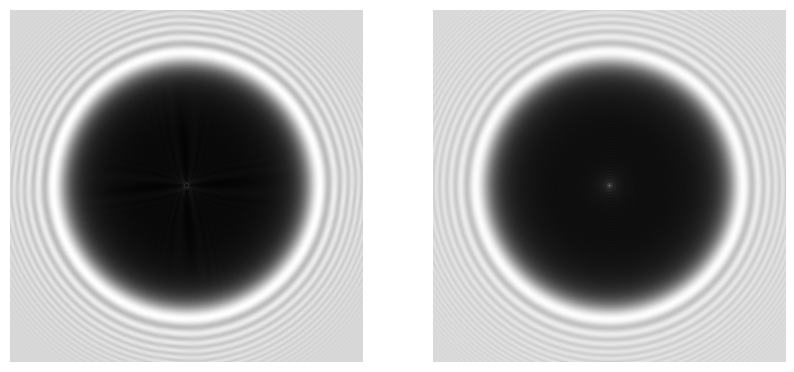

In [53]:
UN = Optica_G(A,X,Y,lamb,L/L[0],z[4] )
U0 = Optica(A0,X,Y,z[4]+np.sum(L/L[0]),lamb)


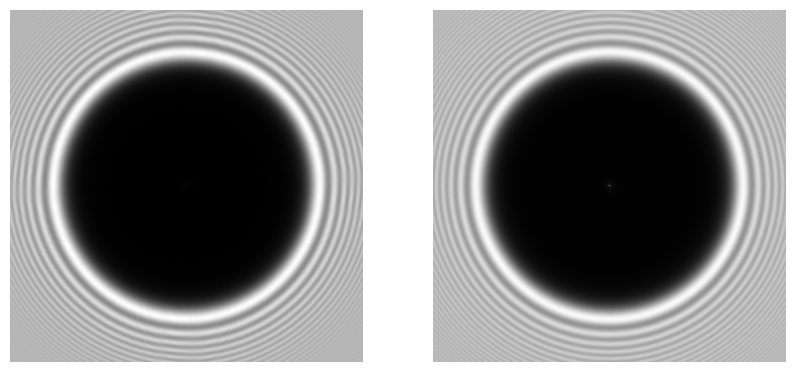

In [56]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(1,2)

ax1 = fig.add_subplot(gs[0,0])
im = ax1.imshow(abs(np.transpose(UN[np.where(abs(x)<1.5*R)[0]])[np.where(abs(x)<1.5*R)[0]])**2,cmap='gray')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(abs(np.transpose(U0[np.where(abs(x)<1.5*R)[0]])[np.where(abs(x)<1.5*R)[0]])**2,cmap='gray')
ax2.axis('off')

cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.1)  # Add a color bar
cbar.set_label('Intensity', fontsize=12) 

To even more distances

In [6]:
z = np.array([60*R,240*R,360*R,420*R,700*R,900*R,1600*R,2600*R])
lamb = 0.632*10**(-3)
L = np.array(L)

ZN01 = FiguraOptica(A,X,Y,lamb,L,z )
ZZ01 = FiguraOptica2(A0,X,Y,lamb,z+np.sum(L)  )

ZN2 = FiguraOptica(A,X,Y,lamb,L/L[0]*1,z )
ZZ2 = FiguraOptica2(A0,X,Y,lamb,z+np.sum(L/L[0])  )

ZN3 = FiguraOptica(A,X,Y,lamb,L/L[0]*8,z)
ZZ3 = FiguraOptica2(A0,X,Y,lamb,z+np.sum(L/L[0]*8)  )


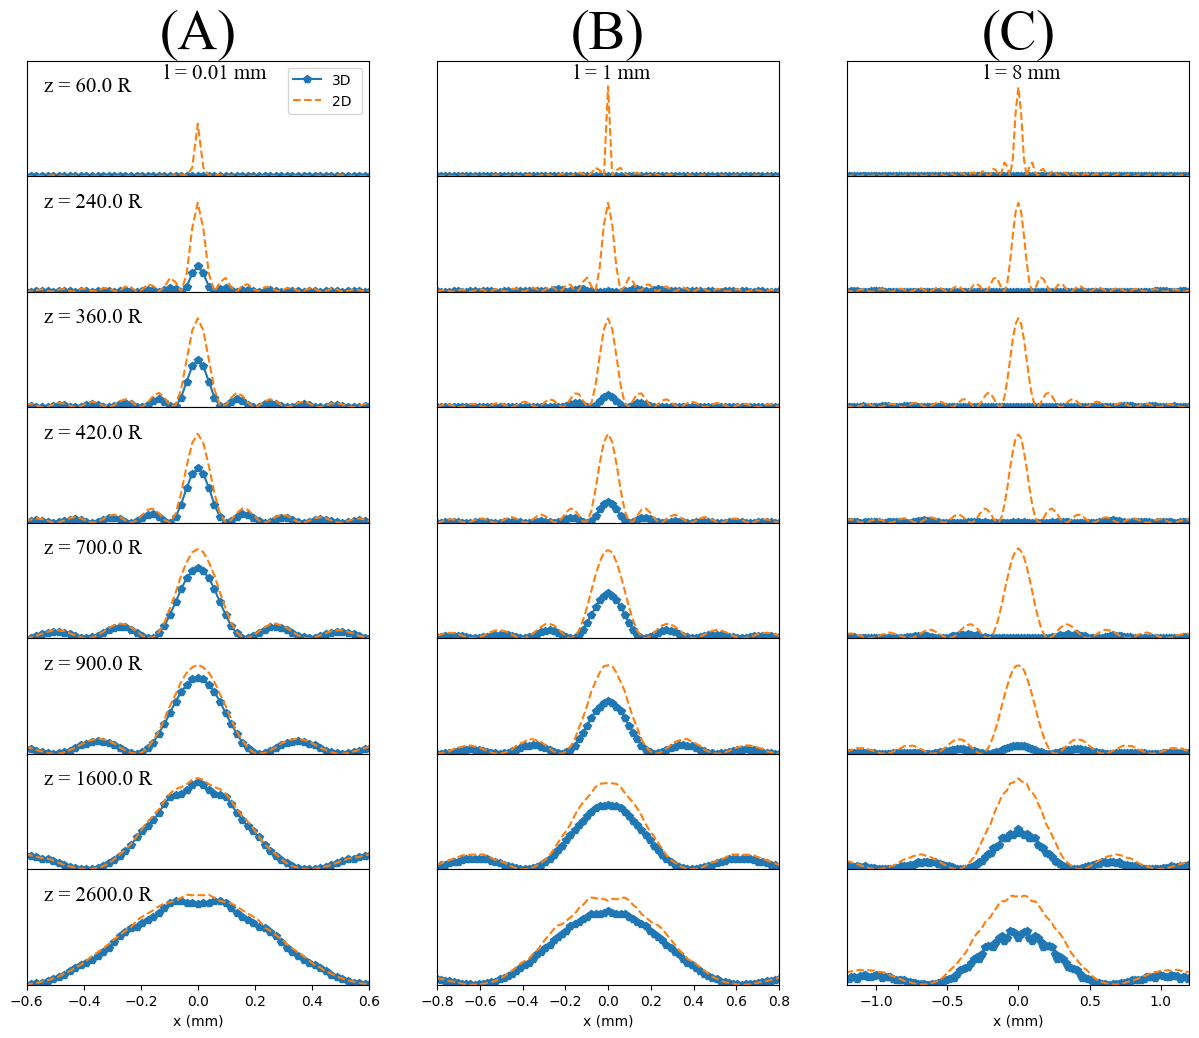

In [10]:
import matplotlib.gridspec as gridspec
b = [[0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6],
     [0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8],
     [1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2]     
     ]
# Create the figure and grid specification
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(len(z),3, hspace=0.0)
l=[0.01,1,8]
llet = ['A','B','C']
# Create subplots in the first column
for j in range(3):
    
    for u in range(len(z)):
        ax1 = fig.add_subplot(gs[u, j])

        # Plot Fourier Optics data
        if j==0:
            UU15 = ZN01[u]
            UUU = ZZ01[u]
        if j==1:
            UU15 = ZN2[u]
            UUU = ZZ2[u]
        if j==2:
            UU15 = ZN3[u]
            UUU = ZZ3[u]

        ax1.plot(x, UU15, 'p-', label=f'3D')
        ax1.plot(x,UUU ,'--',label='2D '  )

        ax1.set_xlim(-b[j][u], b[j][u])  # Ensure consistent x-axis limits
        #ax1.set_ylabel('Intensity')
        ax1.set_ylim(0,1.3)
        ax1.set_yticks([])
        if j==0:
            ax1.annotate(f'z = {round(z[u]/R,2)} R',xy = (0,0),xytext= (-b[j][u]/10*9,0.95), fontname='Times New Roman', fontsize=15   )
        if u == 0:
            ax1.set_title(f'({llet[j]})',fontname='Times New Roman',fontsize=40)
            ax1.annotate(f'l = {round(l[j],2)} mm ',xy = (0,0),xytext= (-2*b[j][u]/10,1.1), fontname='Times New Roman', fontsize=15   )
            if j==0:
                ax1.legend()
        if u < len(z)-1:
            ax1.set_xticks([])
            ax1.xaxis.set_visible(False)
            ax1.xaxis.set_ticks_position('none')
        if u==len(z)-1:
            ax1.set_xlabel('x (mm)')


plt.savefig('Compara-Quad1.png',dpi=300)